
  ****READING THE DATA


In [92]:

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV 


In [93]:
x = r"C:\Users\zaxak\Desktop\Train.csv"
df = pd.read_csv(x)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


>DATA CLEAN




FEATURE ENGINEERING

In [94]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == 'object')

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head())


  Warehouse_block Mode_of_Shipment Product_importance Gender
0               D           Flight                low      F
1               F           Flight                low      M
2               A           Flight                low      M
3               B           Flight             medium      M
4               C           Flight             medium      F
   Warehouse_block  Mode_of_Shipment  Product_importance  Gender
0                3                 0                   1       0
1                4                 0                   1       1
2                0                 0                   1       1
3                1                 0                   2       1
4                2                 0                   2       0


In [95]:
cols_to_keep = [ 
     'Discount_offered', 'Weight_in_gms', 'Warehouse_block',
    'Reached.on.Time_Y.N', 'Customer_rating','Product_importance','Mode_of_Shipment'
]

# Create the final DataFrame with only numerical columns
df = df[cols_to_keep].copy()
df = df.rename(columns={'Reached.on.Time_Y.N': 'Target_On_Time'})

# Display the first few rows showing the new features
print("DataFrame with four new numerical combinations:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

DataFrame with four new numerical combinations:
| Discount_offered   | Weight_in_gms   | Warehouse_block   | Target_On_Time   | Customer_rating   | Product_importance   | Mode_of_Shipment   |
|:-------------------|:----------------|:------------------|:-----------------|:------------------|:---------------------|:-------------------|
| 44                 | 1233            | 3                 | 1                | 2                 | 1                    | 0                  |
| 59                 | 3088            | 4                 | 1                | 5                 | 1                    | 0                  |
| 48                 | 3374            | 0                 | 1                | 2                 | 1                    | 0                  |
| 10                 | 1177            | 1                 | 1                | 3                 | 2                    | 0                  |
| 46                 | 2484            | 2                 | 1                | 2       

DATA SPLIT

In [96]:
# Target variable (y): Select the column you want to predict
y = df['Target_On_Time']

# Features (X): Select all other columns by dropping the target variable
X = df.drop('Target_On_Time', axis=1)

In [97]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Create an ADASYN object
adasyn = ADASYN(sampling_strategy='minority', random_state=42)

# Fit and resample the dataset
X, y = adasyn.fit_resample(X, y)

# Print class distribution before and after resampling
print("Class distribution before ADASYN:", Counter(y))
print("Class distribution after ADASYN:", Counter(y))

Class distribution before ADASYN: Counter({1: 6563, 0: 6274})
Class distribution after ADASYN: Counter({1: 6563, 0: 6274})


In [98]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [99]:
from sklearn.preprocessing import StandardScaler

# 1. CRITICAL: SAVE the original column names BEFORE scaling
original_columns = X_train.columns

scaler = StandardScaler()

# 2. Fit and transform the training data
# This results in a NumPy array.
X_train_scaled_array = scaler.fit_transform(X_train)

# 3. Convert the scaled array back to a DataFrame, 
#    re-applying the original column names
X_train = pd.DataFrame(X_train_scaled_array, columns=original_columns)

# 4. Transform X_test using the same fitted scaler
X_test_scaled_array = scaler.transform(X_test)

# 5. Convert X_test back to a DataFrame (assuming X_test also needs column names)
#    Note: X_test's original columns should be the same as X_train's
X_test = pd.DataFrame(X_test_scaled_array, columns=original_columns)

# X_train and X_test are now scaled DataFrames with their column names intact.

****MODEL CREATION*******

In [100]:
#RANDOM FOREST CLASSIFIER


rf_model = RandomForestClassifier(random_state=42).fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)
y_probalities_RF = rf_model.predict_proba(X_test)
y_probs_rf = y_probalities_RF[:, 1]


In [101]:
print('accuracy:',accuracy_score(y_test,rf_predictions))
print('f1:',f1_score(y_test,rf_predictions))
print(confusion_matrix(y_test,rf_predictions))
print('recall:',recall_score(y_test,rf_predictions))
print('precision:',precision_score(y_test,rf_predictions))
print('auc:',roc_auc_score(y_test,y_probs_rf))

accuracy: 0.6728971962616822
f1: 0.6461668070766639
[[961 294]
 [546 767]]
recall: 0.5841584158415841
precision: 0.7229029217719133
auc: 0.746417225234629


In [102]:
#SVM
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train, y_train)

# Get predictions and probabilities
svc_predictions = svc_model.predict(X_test)
svc_probabilities = svc_model.predict_proba(X_test)[:, 1] 

# Evaluate Baseline Performance
print("--- SVC BASELINE METRICS (Default Settings) ---")
print('Accuracy:', accuracy_score(y_test, svc_predictions))
print('F1:', f1_score(y_test, svc_predictions))
print('AUC:', roc_auc_score(y_test, svc_probabilities))
print('Confusion Matrix:\n', confusion_matrix(y_test, svc_predictions))
print('Recall:', recall_score(y_test, svc_predictions))
print('Precicion:',precision_score(y_test, svc_predictions))

--- SVC BASELINE METRICS (Default Settings) ---
Accuracy: 0.6935358255451713
F1: 0.6074812967581047
AUC: 0.7387525298653065
Confusion Matrix:
 [[1172   83]
 [ 704  609]]
Recall: 0.4638233054074638
Precicion: 0.880057803468208


In [103]:
#LOGISTIC REGRESIION
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression().fit(X_train,y_train)
log_preds=log_reg.predict(X_test)
y_probalities_log = log_reg.predict_proba(X_test)
y_probs_log = y_probalities_log[:, 1]


In [104]:
print('accuracy:',accuracy_score(y_test,log_preds))
print('f1:',f1_score(y_test,log_preds))
print(confusion_matrix(y_test,log_preds))
print('recall:',recall_score(y_test,log_preds))
print('precision:',precision_score(y_test,log_preds))
print('auc:',roc_auc_score(y_test,y_probs_log))

accuracy: 0.6732866043613707
f1: 0.6235980260206371
[[1034  221]
 [ 618  695]]
recall: 0.5293221629855294
precision: 0.7587336244541485
auc: 0.7160427596544515


In [105]:
#KNN
import matplotlib.pyplot as plt
from sklearn.neighbors  import KNeighborsClassifier


	# Set up a KNN Classifier
knn = KNeighborsClassifier().fit(X_train,y_train)
  #  accuracy
knn_predicts=knn.predict(X_test)
y_probalities_knn = knn.predict_proba(X_test)
y_probs_knn = y_probalities_knn[:, 1]




In [106]:
print('accuracy:',accuracy_score(y_test,knn_predicts))
print('f1:',f1_score(y_test,knn_predicts))
print(confusion_matrix(y_test,knn_predicts))
print('recall:',recall_score(y_test,knn_predicts))
print('precision:',precision_score(y_test,knn_predicts))
print('auc:',roc_auc_score(y_test,y_probs_knn))

accuracy: 0.6612149532710281
f1: 0.6304163126593033
[[956 299]
 [571 742]]
recall: 0.5651180502665651
precision: 0.712776176753122
auc: 0.7171584795623295


In [107]:
#DECISION TREE
Dec_Tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
predictions=Dec_Tree.predict(X_test)
y_probalities_dec = Dec_Tree.predict_proba(X_test)
y_probs_dec = y_probalities_dec[:, 1]

In [108]:
print('accuracy:',accuracy_score(y_test,predictions))
print('f1:',f1_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print('recall:',recall_score(y_test,predictions))
print('precision:',precision_score(y_test,predictions))
print('auc:',roc_auc_score(y_test,y_probs_dec))

accuracy: 0.6721183800623053
f1: 0.674400618716164
[[854 401]
 [441 872]]
recall: 0.6641279512566641
precision: 0.6849960722702279
auc: 0.6721692058877968


In [109]:
#XGBOOST
from xgboost import XGBClassifier
Xgboost=XGBClassifier(random_state=42).fit(X_train,y_train)
Xg_preds=Xgboost.predict(X_test)
y_probalities_xg = Xgboost.predict_proba(X_test)
y_probs_xg = y_probalities_xg[:, 1]

In [110]:
print('accuracy:',accuracy_score(y_test,Xg_preds))
print('f1:',f1_score(y_test,Xg_preds))
print(confusion_matrix(y_test,Xg_preds))
print('recall:',recall_score(y_test,Xg_preds))
print('precision:',precision_score(y_test,Xg_preds))
print('auc:',roc_auc_score(y_test,y_probs_xg))

accuracy: 0.6943146417445483
f1: 0.6487695749440716
[[1058  197]
 [ 588  725]]
recall: 0.5521706016755522
precision: 0.7863340563991323
auc: 0.7454869023525093


#*****************HYPERPARAMETERS

In [111]:
#What are the hyperparameters for each model ?
#KNN
print('KNN:',knn.get_params().keys())
#RANDOM FOREST CLASSIFIER
print('Random Forest:',rf_model.get_params().keys())
print('Decision Tree:',Dec_Tree.get_params().keys())
print('Xgboost',Xgboost.get_params().keys())
print('Logistic regression:',log_reg.get_params().keys())
print('SVM:',svc_model.get_params().keys())

KNN: dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Decision Tree: dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])
Xgboost dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_cons

DECISION TREE TUNING


In [112]:
#GRIDSEARCH FOR DECICION TREE
param_grid_DCT={'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'max_features' : ['sqrt','log2'],
               'min_samples_leaf' : [1,5,10,20],
               'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1],
               'class_weight': ['balanced',  None],
               'max_leaf_nodes': [5, 10, 20, 50, 100],
               'min_impurity_decrease' : [0.0, 0.0005, 0.005, 0.01, 0.05],
               'min_samples_split': [2, 5, 10, 20, 50],
               'min_weight_fraction_leaf': [0.0, 0.001, 0.005, 0.01]
            }
                
random_search_DC = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, ), # XGBoost setup
    param_distributions=param_grid_DCT,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    error_score='raise' # Set a random state for reproducibility
)
random_search_DC.fit(X_train, y_train)
print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_DC.best_params_)


--- RandomizedSearchCV Best Parameters ---
{'min_weight_fraction_leaf': 0.001, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'log_loss', 'class_weight': 'balanced', 'ccp_alpha': 0.001}


In [138]:
best_params = {'min_weight_fraction_leaf': 0.001, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'log_loss', 'class_weight': 'balanced', 'ccp_alpha': 0.001}


Dec_Tree_tuned=DecisionTreeClassifier(**best_params,random_state=42) 
Dec_Tree_tuned.fit(X_train,y_train)
predict=Dec_Tree_tuned.predict(X_test)

y_proba_all_dec = Dec_Tree_tuned.predict_proba(X_test)
y_scores_dec = y_proba_all_dec[:, 1]


In [139]:
print('accuracy:',accuracy_score(y_test,predict))
print('f1:',f1_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print('recall:',recall_score(y_test,predict))
print('precision:',precision_score(y_test,predict))
print('AUC',roc_auc_score(y_test,y_scores_dec))

accuracy: 0.6939252336448598
f1: 0.62320230105465
[[1132  123]
 [ 663  650]]
recall: 0.49504950495049505
precision: 0.8408796895213454
AUC 0.7470598944663085


*KNN TUNING and complexity visualization


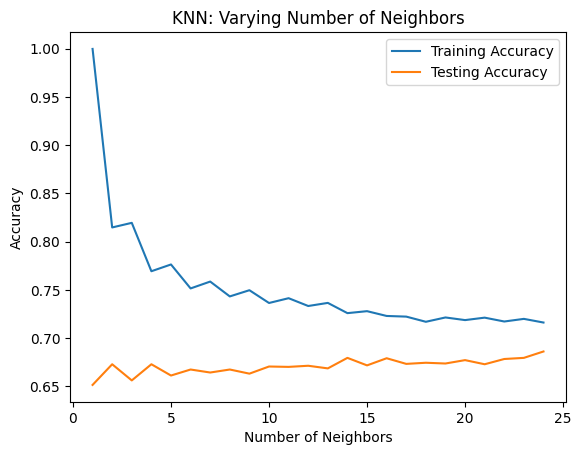

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
 {np.int64(1): 0.9997078586035641, np.int64(2): 0.8146849741941766, np.int64(3): 0.8194566170026293, np.int64(4): 0.7693056772811374, np.int64(5): 0.7763170707955984, np.int64(6): 0.751485052098549, np.int64(7): 0.7585938260784887, np.int64(8): 0.7432077125328659, np.int64(9): 0.7496348232544552, np.int64(10): 0.7363910799493621, np.int64(11): 0.7413574836887721, np.int64(12): 0.7332749050540461, np.int64(13): 0.7364884604148407, np.int64(14): 0.7258739896776707, np.int64(15): 0.7279189794527218, np.int64(16): 0.722952575713312, np.int64(17): 0.7222709124549616, np.int64(18): 0.7169149868536372, np.int64(19): 0.7213944882656539, np.int64(20): 0.7186678352322524, np.int64(21): 0.7211997273346966, np.int64(22): 0.717207128250073, np.int64(23): 0.7199337812834745, np.int64(24): 0.7161359431298081} 
 {np.int64(1): 0.6514797507788161, np.int64(2): 0.6728971962616822, np.int64(3): 0.6561526479750779, np.int64(4): 0.67

In [115]:
neighbors = np.arange(1, 25)
train_accuracies = {}
test_accuracies = {}
for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)

# PLOT MODEL COMPLEXITY
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)


In [116]:
# Find the key corresponding to the maximum value
best_key = max(test_accuracies, key=test_accuracies.get)
best_value = test_accuracies[best_key]

print(f"K={best_key} is the best value for the hyperparameter 'n_neighbors', to maximize accuracy ")
print(f"Highest value: {best_value:.4f}")


K=24 is the best value for the hyperparameter 'n_neighbors', to maximize accuracy 
Highest value: 0.6861


In [117]:
#More KNN hyperparameters to tune
param_grid_KNN={'n_neighbors': range(1,26),
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20,30,40]
}
grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid_KNN,cv=5,n_jobs=-1,scoring='accuracy')
grid_knn.fit(X_train,y_train)
grid_knn.best_params_

{'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 20}

In [118]:
best_knn_params={'algorithm': 'ball_tree',
 'leaf_size': 20,
 'n_neighbors': 22,
 }
Tuned_KNN=KNeighborsClassifier(**best_knn_params)
Tuned_KNN.fit(X_train,y_train)
KNN_predictionS=Tuned_KNN.predict(X_test)
y_proba_all_KNN = Tuned_KNN.predict_proba(X_test)
y_scores_KNN = y_proba_all_KNN[:, 1]

In [119]:
print('accuracy:',accuracy_score(y_test,KNN_predictionS))
print('f1:',f1_score(y_test,KNN_predictionS))
print(confusion_matrix(y_test,KNN_predictionS))
print('recall:',recall_score(y_test,KNN_predictionS))
print('precision:',precision_score(y_test,KNN_predictionS))
print('AUC',roc_auc_score(y_test,y_scores_KNN))

accuracy: 0.6783489096573209
f1: 0.6028846153846154
[[1115  140]
 [ 686  627]]
recall: 0.4775323686214775
precision: 0.817470664928292
AUC 0.7320715614313499


**RANDOMFOREST TUNE


In [120]:
# RANDOM FOREST TUNING
param_grid_RF = {'n_estimators': range(10, 50, 10),
'criterion' : ["gini", "entropy",'log_loss'],
'max_depth' : [None, 5, 10, 20],
'bootstrap' : [True, False],
'min_samples_split' : [2,5,10,20],
'max_features' : ['sqrt','log2']
}

# Optimize for a RandomForestClassifier() using GridSearchCV
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_RF, cv=5,n_jobs=-1,scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'n_estimators': 20}

In [121]:
best_rf_params={'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'n_estimators': 20}
Tuned_RF=RandomForestClassifier(**best_rf_params,random_state=42,n_jobs=-1)
Tuned_RF.fit(X_train,y_train)
rf_tuned_predictions=Tuned_RF.predict(X_test)
y_proba_all_RF = Tuned_RF.predict_proba(X_test)
y_scores_RF = y_proba_all_RF[:, 1]




In [122]:
print('accuracy:',accuracy_score(y_test,rf_tuned_predictions))
print('f1:',f1_score(y_test,rf_tuned_predictions))
print(confusion_matrix(y_test,rf_tuned_predictions))
print('recall:',recall_score(y_test,rf_tuned_predictions))
print('precision:',precision_score(y_test,rf_tuned_predictions))
print('AUC',roc_auc_score(y_test,y_scores_RF))

accuracy: 0.714563862928349
f1: 0.6329494241362043
[[1203   52]
 [ 681  632]]
recall: 0.48134044173648133
precision: 0.9239766081871345
AUC 0.7505957889690287


*LOG REGRESSION TUNE


In [123]:
param_grid_lg ={
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
   
   
grid_search_lg = GridSearchCV(LogisticRegression(solver='liblinear'),
    param_grid_lg,
    scoring='accuracy',
    cv=5,                 # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available CPU cores
)
grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

In [124]:
lg_best={'C': 0.001, 'max_iter': 2000, 'penalty': 'l2'}


Tuned_lg=LogisticRegression(**lg_best,random_state=42,solver='saga')
Tuned_lg.fit(X_train,y_train)
LG_tuned_predictions=Tuned_lg.predict(X_test)
y_proba_all_lg = Tuned_lg.predict_proba(X_test)
y_scores_lg = y_proba_all_lg[:, 1]


In [125]:
print(confusion_matrix(y_test,LG_tuned_predictions))
print('PRECICION:',precision_score(y_test,LG_tuned_predictions))
print('f1:',f1_score(y_test,LG_tuned_predictions))
print('recall',recall_score(y_test,LG_tuned_predictions))
print('accuracy',accuracy_score(y_test,LG_tuned_predictions))
y=roc_auc_score(y_test,y_scores_lg)
print('AUC',y)

[[1020  235]
 [ 614  699]]
PRECICION: 0.7483940042826552
f1: 0.6221628838451269
recall 0.5323686214775324
accuracy 0.669392523364486
AUC 0.720501998100515


****SVM TUNE

In [126]:

param_grid_SVC = {
    'C': [0.1, 1, 10],            
    'kernel': ['rbf', 'poly'],    
    'gamma': ['scale', 'auto']    
}


grid_SVC = GridSearchCV(
    SVC(random_state=42, probability=True), 
    param_grid_SVC, 
    cv=5,                      
    n_jobs=-1,                 
)

grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_





{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

In [127]:
svm_best={'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Tuned_svm=SVC(**svm_best,random_state=42,probability=True)
Tuned_svm.fit(X_train,y_train)
SVM_tuned_predictions=Tuned_svm.predict(X_test)
y_proba_all_svm1 = Tuned_svm.predict_proba(X_test)
y_scores_svm1 = y_proba_all_svm1[:, 1]

In [128]:
print(confusion_matrix(y_test,SVM_tuned_predictions))
print('PRECICION:',precision_score(y_test,SVM_tuned_predictions))
print('f1:',f1_score(y_test,SVM_tuned_predictions))
print('recall',recall_score(y_test,SVM_tuned_predictions))
print('accuracy',accuracy_score(y_test,SVM_tuned_predictions))
y=roc_auc_score(y_test,y_scores_svm1)
print('AUC',y)

[[1172   83]
 [ 704  609]]
PRECICION: 0.880057803468208
f1: 0.6074812967581047
recall 0.4638233054074638
accuracy 0.6935358255451713
AUC 0.7387525298653065



***XGBOOST TUNE


In [129]:
param_grid_XG = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma':[0, 0.1, 0.2],
        'min_child_weight':[1, 3, 5, 7],
        'grow_policy':['depthwise','lossguide'],
        'booster':['gbtree','gblinear','dart'],
        'scale_pos_weight': [1, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0]
        }
random_search_XG = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'), # XGBoost setup
    param_distributions=param_grid_XG,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 # Set a random state for reproducibility
)
random_search_XG.fit(X_train, y_train)
print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_XG.best_params_)


--- RandomizedSearchCV Best Parameters ---
{'subsample': 0.7, 'scale_pos_weight': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'gamma': 0, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


In [130]:
xg_best={'subsample': 0.7, 'scale_pos_weight': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'gamma': 0, 'colsample_bytree': 0.8, 'booster': 'gbtree'}

Tuned_xg=XGBClassifier(**xg_best,random_state=42,n_jobs=-1)
Tuned_xg.fit(X_train,y_train)
XG_tuned_predictions=Tuned_xg.predict(X_test)
y_proba_all = Tuned_xg.predict_proba(X_test)
y_scores = y_proba_all[:, 1]


In [131]:
print(confusion_matrix(y_test,XG_tuned_predictions))
print('PRECICION:',precision_score(y_test,XG_tuned_predictions))
print('f1:',f1_score(y_test,XG_tuned_predictions))
print('recall',recall_score(y_test,XG_tuned_predictions))
print('accuracy',accuracy_score(y_test,XG_tuned_predictions))
y=roc_auc_score(y_test,y_scores)
print('auc',y)



[[1237   18]
 [ 719  594]]
PRECICION: 0.9705882352941176
f1: 0.6171428571428571
recall 0.4523990860624524
accuracy 0.713006230529595
auc 0.7521751531573628


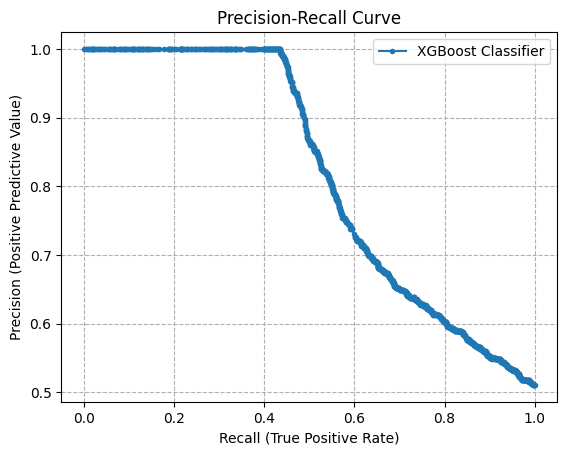

In [132]:
precision, recall, thresholds = precision_recall_curve( y_test,y_scores )
plt.plot(recall, precision, marker='.', label='XGBoost Classifier')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.grid(True, linestyle='--')

plt.legend()



In [137]:
# Define your new optimal threshold
OPTIMAL_THRESHOLD = 0.4

# Convert probability scores (y_scores) into binary predictions (0 or 1)
# 1 if score >= threshold, else 0
y_pred_new = np.where(y_scores >= OPTIMAL_THRESHOLD, 1, 0)
new_recall = recall_score(y_test, y_pred_new)
new_precision = precision_score(y_test, y_pred_new)
new_cm = confusion_matrix(y_test, y_pred_new)
print('f1',f1_score(y_test, y_pred_new))
print('accuracy',accuracy_score(y_test, y_pred_new))
print('AUC',roc_auc_score(y_test,y_scores))


print(f"--- Performance at Threshold {OPTIMAL_THRESHOLD} ---")
print(f"New Recall:    {new_recall:.4f}")
print(f"New Precision: {new_precision:.4f}")
print(f"Confusion Matrix:\n{new_cm}")

f1 0.6723247232472325
accuracy 0.6542056074766355
AUC 0.7521751531573628
--- Performance at Threshold 0.4 ---
New Recall:    0.6938
New Precision: 0.6521
Confusion Matrix:
[[769 486]
 [402 911]]


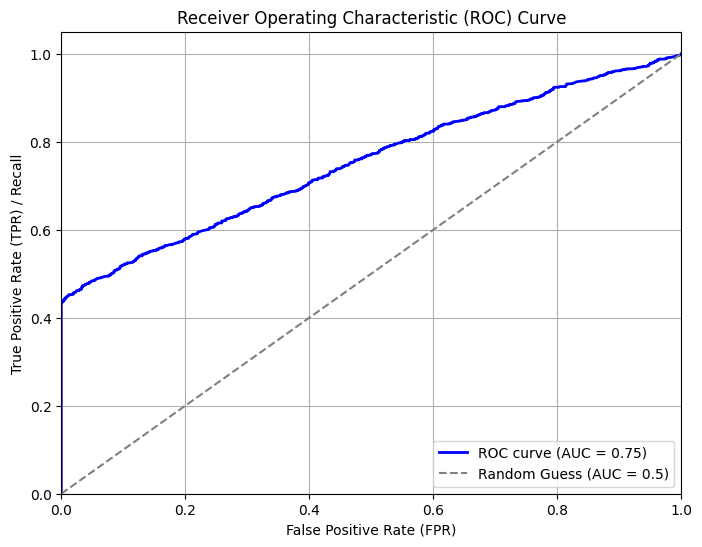

In [134]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = 0.75)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()